In [4]:
!pip install pmdarima
!pip install plotly
!pip install skits

     |████████████████████████████████| 1.5MB 10.7MB/s 
     |████████████████████████████████| 9.5MB 44.2MB/s 
     |████████████████████████████████| 2.1MB 42.8MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
  Found existing installation: Cython 0.29.22
    Uninstalling Cython-0.29.22:
      Successfully uninstalled Cython-0.29.22


In [5]:
import numpy as np 
import pandas as pd
import plotly.express as px
from plotly import graph_objects
import itertools
import warnings 
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import statsmodels.formula.api as smf
from statsmodels.tsa.arima_model import ARMA
from pmdarima.arima import ADFTest
from statsmodels.tsa.seasonal import seasonal_decompose 
from pmdarima import auto_arima 
from skits.preprocessing import (ReversibleImputer,
                                 DifferenceTransformer)
from skits.pipeline import ForecasterPipeline
from sklearn.preprocessing import StandardScaler

**Load Dataset**

In [7]:
data = pd.read_csv('/content/drive/MyDrive/Datasets/stocks.csv', index_col='Date', parse_dates = True)

print(data)

            Unnamed: 0       Open       High       Low    Close
Date                                                           
2021-02-19          99  2107.7900  2118.5800  2083.430  2088.81
2021-02-18          98  2105.0000  2121.9900  2093.330  2105.81
2021-02-17          97  2093.9800  2122.4434  2088.350  2118.62
2021-02-16          96  2091.7500  2145.1400  2091.750  2110.70
2021-02-12          95  2079.7700  2099.5000  2073.570  2095.03
...                ...        ...        ...       ...      ...
2020-10-02           4  1459.6300  1479.0300  1447.350  1455.60
2020-10-01           3  1483.6608  1495.0700  1476.800  1487.90
2020-09-30           2  1460.9350  1486.1975  1455.755  1465.60
2020-09-29           1  1463.9100  1472.0000  1454.000  1466.02
2020-09-28           0  1471.9900  1472.9900  1446.280  1458.66

[100 rows x 5 columns]


In [9]:
print(data.Open)

Date
2021-02-19    2107.7900
2021-02-18    2105.0000
2021-02-17    2093.9800
2021-02-16    2091.7500
2021-02-12    2079.7700
                ...    
2020-10-02    1459.6300
2020-10-01    1483.6608
2020-09-30    1460.9350
2020-09-29    1463.9100
2020-09-28    1471.9900
Name: Open, Length: 100, dtype: float64


In [10]:

y = data.Open
fig = px.line(data, x=data.index, y='Open', title='Google Stock Prices')
fig.show()

**ARIMA**

* p is the auto-regressive part of the model, incorporating the effect of the past.

* d is the integrated part of the model. This includes terms in the model that incorporate the amount of differencing: the number of past times to subtract from the present time.

* q is the moving average part of the model. This allows us to set the error of our model as a linear combination of the error values observed at previous time points in the past.

* When dealing with seasonal effects, we make use of the seasonal ARIMA, which is denoted as ARIMA(p,d,q)(P,D,Q)s. Here, (p, d, q) are the non-seasonal parameters described above, while (P, D, Q) follow the same definition but are applied to the seasonal component of the time series. The term s is the periodicity of the time series (4 for quarterly periods, 12 for yearly periods, etc.).



**Model**

* When looking to fit time series data with a seasonal ARIMA model, our first goal is to find the values of ARIMA(p,d,q)(P,D,Q)s that optimize a metric of interest. 

In [11]:
# Fit auto_arima function to  dataset 
stepwise_fit = auto_arima(data['Open'], start_p = 1, start_q = 1, 
                          max_p = 3, max_q = 3, m = 12, 
                          start_P = 0, seasonal = True, 
                          d = None, D = 1, trace = True, 
                          error_action ='ignore',   # we don't want to know if an order does not work 
                          suppress_warnings = True,  # we don't want convergence warnings 
                          stepwise = True)           # set to stepwise 

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.82 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1063.869, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=916.285, Time=0.57 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.73 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1107.138, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=949.339, Time=0.11 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=905.284, Time=1.59 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=905.819, Time=2.69 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=904.776, Time=0.60 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=inf, Time=0.49 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=inf, Time=2.99 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=903.840, Time=1.33 sec
 ARIMA(0,0,0)(0,1,2)[12] intercept   : AIC=inf, Time=1.67 sec
 ARIMA(2,0,0)(0,1,2)[12] intercept   : AIC=905.721, Time=2.01 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=905.732,

In [12]:
stepwise_fit.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  100
Model:             SARIMAX(1, 0, 0)x(0, 1, 2, 12)   Log Likelihood                -446.920
Date:                            Tue, 23 Mar 2021   AIC                            903.840
Time:                                    00:45:13   BIC                            916.227
Sample:                                         0   HQIC                           908.831
                                            - 100                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -4.9361      3.715     -1.329      0.184     -12.217       2.345
ar.L1          0.9306      0.047     19.691      0.000       0.838       1.023
ma.S.L12      -0.9976      0.145     -6.872      0.000      -1.282      -0.713
ma.S.L24       0.3461      0.173      2.005      0.045       0.008       0.684
sigma2      1307.1622    147.255      8.877      0.000    1018.547    1595.777
===================================================================================
Ljung-Box (Q):                       38.85   Jarque-Bera (JB):                21.97
Prob(Q):                              0.52   Prob(JB):                         0.00
Heteroskedasticity (H):               1.12   Skew:                            -0.45
Prob(H) (two-sided):                  0.76   Kurtosis:                         5.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [13]:
# Split data into train / test sets 
train = data.iloc[:len(data)-12] 
test = data.iloc[len(data)-12:] # set one year(12 months) for testing 

In [14]:
print(test)

            Unnamed: 0       Open       High       Low    Close
Date                                                           
2020-10-13          11  1577.0100  1585.1600  1558.630  1567.07
2020-10-12          10  1538.0000  1588.4200  1529.300  1564.59
2020-10-09           9  1492.8600  1511.8500  1487.000  1510.45
2020-10-08           8  1465.4500  1488.0275  1465.450  1483.43
2020-10-07           7  1459.3100  1468.9700  1433.230  1459.14
2020-10-06           6  1475.5000  1484.5200  1445.010  1451.02
2020-10-05           5  1462.6500  1484.7000  1460.090  1482.83
2020-10-02           4  1459.6300  1479.0300  1447.350  1455.60
2020-10-01           3  1483.6608  1495.0700  1476.800  1487.90
2020-09-30           2  1460.9350  1486.1975  1455.755  1465.60
2020-09-29           1  1463.9100  1472.0000  1454.000  1466.02
2020-09-28           0  1471.9900  1472.9900  1446.280  1458.66


In [15]:
print(train)

            Unnamed: 0     Open       High        Low    Close
Date                                                          
2021-02-19          99  2107.79  2118.5800  2083.4300  2088.81
2021-02-18          98  2105.00  2121.9900  2093.3300  2105.81
2021-02-17          97  2093.98  2122.4434  2088.3500  2118.62
2021-02-16          96  2091.75  2145.1400  2091.7500  2110.70
2021-02-12          95  2079.77  2099.5000  2073.5700  2095.03
...                ...      ...        ...        ...      ...
2020-10-20          16  1523.11  1573.8400  1520.5000  1551.08
2020-10-19          15  1575.93  1583.9250  1522.9200  1529.95
2020-10-16          14  1561.83  1577.7100  1557.6600  1567.70
2020-10-15          13  1544.50  1571.3950  1541.1301  1555.47
2020-10-14          12  1574.60  1583.8500  1545.8950  1563.44

[88 rows x 5 columns]


In [16]:
from statsmodels.tsa.statespace.sarimax import SARIMAX 
  
model = SARIMAX(train['Open'],  
                order = (0, 1, 1),  
                seasonal_order =(2, 1, 1, 12)) 
  
result = model.fit() 
result.summary() 

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                               Open   No. Observations:                   88
Model:             SARIMAX(0, 1, 1)x(2, 1, 1, 12)   Log Likelihood                -385.497
Date:                            Tue, 23 Mar 2021   AIC                            780.994
Time:                                    00:45:44   BIC                            792.581
Sample:                                         0   HQIC                           785.620
                                             - 88                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0128      0.152     -0.084      0.933      -0.310       0.284
ar.S.L12      -1.2629      0.280     -4.509      0.000      -1.812      -0.714
ar.S.L24      -0.5975      0.161     -3.702      0.000      -0.914      -0.281
ma.S.L12       0.5011      0.358      1.401      0.161      -0.200       1.202
sigma2      1503.3638    194.707      7.721      0.000    1121.745    1884.983
===================================================================================
Ljung-Box (Q):                       25.67   Jarque-Bera (JB):                22.78
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               1.33   Skew:                            -0.38
Prob(H) (two-sided):                  0.48   Kurtosis:                         5.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [17]:
start = len(train) 
end = len(train) + len(test) - 1
  
# Predictions for one-year against the test set 
predictions = result.predict(start, end, typ = 'levels').rename("Predictions") 

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



In [18]:
print(predictions)

88    1537.825807
89    1518.636830
90    1509.128529
91    1523.591674
92    1514.407615
93    1543.170951
94    1509.696534
95    1515.137431
96    1484.464560
97    1429.302396
98    1426.444208
99    1459.629303
Name: Predictions, dtype: float64


In [19]:
print(predictions.index)

RangeIndex(start=88, stop=100, step=1)


In [20]:
from sklearn.metrics import mean_squared_error 
from statsmodels.tools.eval_measures import rmse

In [22]:
# Calculate root mean squared error 
rmse(test["Open"], predictions) 

41.85565348734983

In [23]:
# Calculate mean squared error 
mean_squared_error(test["Open"], predictions) 

1751.8957288530999

In [24]:
# Train the model on the full dataset 
model = model = SARIMAX(data['Open'],  
                        order = (0, 1, 1),  
                        seasonal_order =(2, 1, 1, 12)) 
result = model.fit() 
  
# Forecast for the next 3 years 
forecast = result.predict(start = len(data),  
                          end = (len(data)-1) + 3 * 12,  
                          typ = 'levels').rename('Forecast') 

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



In [25]:
print(forecast)

100    1408.897570
101    1410.757149
102    1418.316026
103    1430.069151
104    1420.894399
105    1438.136056
106    1409.071419
107    1398.863384
108    1397.254522
109    1356.006341
110    1347.999989
111    1380.253841
112    1312.472208
113    1309.167352
114    1307.010780
115    1308.412926
116    1303.638334
117    1304.002354
118    1286.131635
119    1266.018653
120    1293.400366
121    1268.857354
122    1261.904699
123    1283.942869
124    1242.436457
125    1228.722153
126    1215.404047
127    1210.827619
128    1203.854653
129    1216.337686
130    1195.831858
131    1185.548731
132    1200.411888
133    1169.960339
134    1166.051662
135    1187.230085
Name: Forecast, dtype: float64


**Prophet**

In [ ]:
from fbprophet import Prophet

In [ ]:
data_prophet = pd.read_csv('/content/drive/MyDrive/Datasets/stocks.csv', parse_dates = True)

In [ ]:
print(data_prophet.ds)

In [ ]:
# define the model
model = Prophet()
# fit the model
model.fit(data_prophet)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
future = model.make_future_dataframe(periods=365)
print(future)

            ds
0   2015-01-01
1   2015-01-02
2   2015-01-03
3   2015-01-04
4   2015-01-05
..         ...
396 2018-01-08
397 2018-01-09
398 2018-01-10
399 2018-01-11
400 2018-01-12

[401 rows x 1 columns]


In [ ]:
future.to_csv('/content/drive/MyDrive/Sales_Future_Prophet.csv')

In [ ]:
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2015-01-01,9834.293950,-6595.219550,24375.378010
1,2015-01-02,25712.453757,10399.522096,43108.005842
2,2015-01-03,29371.757361,12566.084454,45282.758275
3,2015-01-04,25905.271148,9957.705931,41363.231875
4,2015-01-05,32026.776174,15779.804371,47572.724637
...,...,...,...,...
396,2018-01-08,49418.482864,33250.783343,66036.615496
397,2018-01-09,55978.522292,40659.087368,72899.642467
398,2018-01-10,61711.619347,46750.249942,79306.005625
399,2018-01-11,78235.423303,62146.580879,95065.579152


In [ ]:
forecast.to_csv('/content/drive/MyDrive/Sales_Forecast_Prophet.csv')

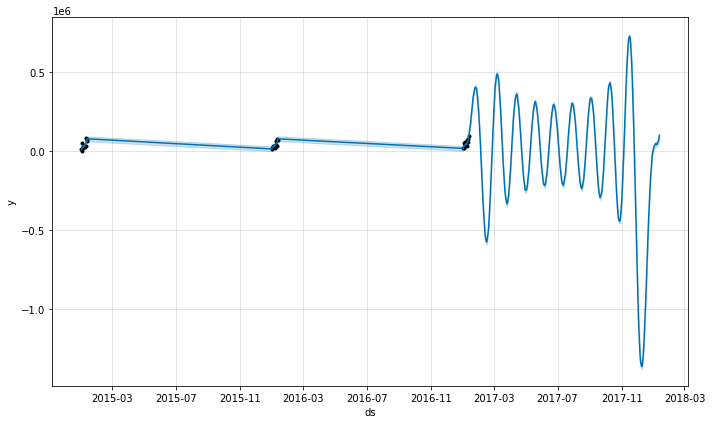

In [ ]:
fig_prophet = model.plot(forecast)


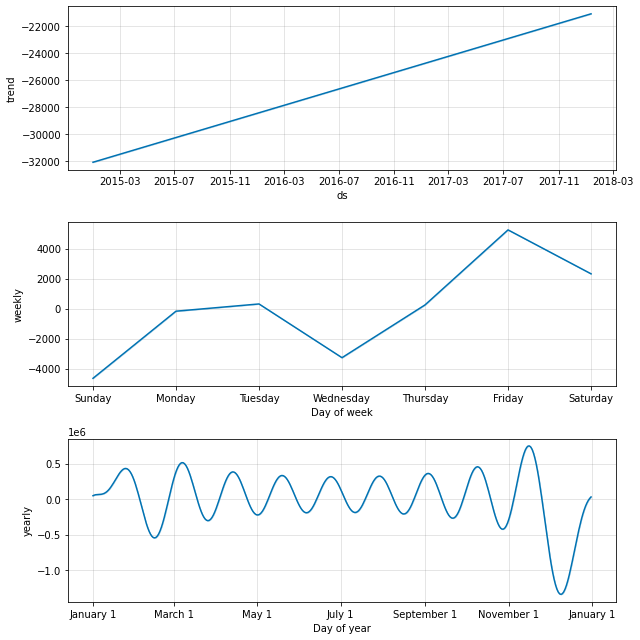

In [ ]:
fig2 = model.plot_components(forecast)

In [ ]:
from fbprophet.plot import plot_plotly, plot_components_plotly

plot_plotly(model, forecast)

In [ ]:
plot_components_plotly(model, forecast)